In [32]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# String matching libs:
import pyjarowinkler
from pyjarowinkler import distance as jw
import Levenshtein
import fuzzy
from fuzzywuzzy import fuzz
import jellyfish

In [2]:
'''
df = pd.read_csv('name_election_features_20190616_1M.csv',
                 sep='\t',
                 header=None,
                 error_bad_lines=False,engine='python'
    )
'''

"\ndf = pd.read_csv('name_election_features_20190616_1M.csv',\n                 sep='\t',\n                 header=None,\n                 error_bad_lines=False,engine='python'\n    )\n"

In [3]:
%%query_hive --hiveserver prod-agatti-dp-m-2
SELECT
  t1.*
FROM data.name_election_features t1
JOIN (  -- Sampling ~100k phone numbers gives ~1M contacts
    SELECT 
      DISTINCT tin.phone_number 
    FROM(
     SELECT 
       phone_number 
     FROM data.name_election_features 
     WHERE dt='20190721' 
     AND country_code='IN'
     AND LENGTH(phone_number)>6
     AND rand(1)<0.001) tin
    LIMIT 100000
) tin2
ON t1.phone_number = tin2.phone_number
WHERE t1.dt='20190721'
LIMIT 1100000

Query took: 1110.087623 seconds


,phone_number,country_code,profile_name,transliterated_profile_name,elected_name,transliterated_elected_name,candidate_name,transliterated_candidate_name,source,email_domain,...,old_ne_weight,num_contacts_provided,match_score_ugc_avg,num_contacts_with_ver_prof,match_score_profile_avg,junkiness_part0,junkiness_part1,junkiness_part2,dt,parameters
0,916000247137,IN,bakker ali,bakker ali,barkha ali hussain,barkha ali hussain,barkha ali hussain,barkha ali hussain,phonebook,,...,7.287920,143.0,0.741626,133.0,0.595979,0.457834,0.205967,0.158066,20190721,sample_0.10
1,916000247137,IN,bakker ali,bakker ali,barkha ali hussain,barkha ali hussain,barkha ali hussain,barkha ali hussain,phonebook,,...,7.287920,143.0,0.741626,133.0,0.595979,0.457834,0.205967,0.158066,20190721,sample_0.10
2,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,rekha monidutta,rekha monidutta,email,gmail.com,...,3.374513,3.0,0.722027,3.0,0.689812,0.447352,0.227540,NaN,20190721,sample_0.10
3,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,rekha monidutta,rekha monidutta,email,gmail.com,...,3.374513,2.0,0.862245,2.0,0.849722,0.447352,0.227540,NaN,20190721,sample_0.10
4,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,rekha monidutta,rekha monidutta,email,gmail.com,...,3.374513,2.0,1.000000,2.0,0.569264,0.447352,0.227540,NaN,20190721,sample_0.10
5,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,ভনীবাইদেউ,bhaniba ide u,phonebook,,...,5.061136,309.0,0.633821,295.0,0.540392,NaN,NaN,NaN,20190721,sample_0.10
6,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,rakha bidew,rakha bidew,phonebook,,...,7.370232,332.0,0.796887,297.0,0.704800,0.369713,NaN,NaN,20190721,sample_0.10
7,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,kishti linaaa.,kishti linaaa,phonebook,,...,1.697544,311.0,0.693187,289.0,0.603616,0.643043,NaN,NaN,20190721,sample_0.10
8,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,rekha bidew whatap,rekha bidew whatap,phonebook,,...,7.328239,190.0,0.818621,173.0,0.674784,0.447352,NaN,0.994079,20190721,sample_0.10
9,916000709425,IN,rekha moni dutta,rekha moni dutta,rekha bidew whatap,rekha bidew whatap,kd,kd,phonebook,,...,0.490861,482.0,0.697099,442.0,0.541624,0.447430,NaN,NaN,20190721,sample_0.10


In [4]:
df = _

In [6]:
df[['country_code', 'candidate_name','transliterated_candidate_name', 'source', 'email_domain', 'register_id',
                        'timestamp', 'str_comp', 'num_words', 'num_chars', 'age_days','old_ne_weight',
                        'num_contacts_provided', 'match_score_ugc_avg', 'num_contacts_with_ver_prof', 'match_score_profile_avg',
                        'junkiness_part0', 'junkiness_part1', 'junkiness_part2']].iloc[0]


country_code                                     IN
candidate_name                   barkha ali hussain
transliterated_candidate_name    barkha ali hussain
source                                    phonebook
email_domain                                       
register_id                        2923546600670928
timestamp                             1542075432000
str_comp                                     12.623
num_words                                         3
num_chars                                        18
age_days                                        251
old_ne_weight                               7.28792
num_contacts_provided                           143
match_score_ugc_avg                        0.741626
num_contacts_with_ver_prof                      133
match_score_profile_avg                    0.595979
junkiness_part0                            0.457834
junkiness_part1                            0.205967
junkiness_part2                            0.158066
Name: 0, dty

In [12]:
# Check for conformity with expectations:
if np.any(df.columns != [
    "phone_number","country_code","profile_name","transliterated_profile_name","elected_name","transliterated_elected_name","candidate_name","transliterated_candidate_name",
    "source","email_domain","register_id","timestamp","str_comp","num_words","num_chars","age_days","old_ne_weight",
    "num_contacts_provided","match_score_ugc_avg","num_contacts_with_ver_prof","match_score_profile_avg",
    "junkiness_part0","junkiness_part1","junkiness_part2","dt","parameters"
]):
    print("Error: Non-conforming DataFrame supplied.  It does not match the expected columns")
    

In [13]:
pd.set_option('display.max_columns', 50)
df.tail()
#pd.set_option('display.max_columns', 20)

,phone_number,country_code,profile_name,transliterated_profile_name,elected_name,transliterated_elected_name,candidate_name,transliterated_candidate_name,source,email_domain,register_id,timestamp,str_comp,num_words,num_chars,age_days,old_ne_weight,num_contacts_provided,match_score_ugc_avg,num_contacts_with_ver_prof,match_score_profile_avg,junkiness_part0,junkiness_part1,junkiness_part2,dt,parameters
1099995,917795739070,IN,gopal krishnan,gopal krishnan,gopal,gopal,gopal,gopal,phonebook,,680365775,1510073966000,253.2754,1,5,621,100.0,240.0,0.764613,232.0,0.644907,0.491545,NaN,NaN,20190721,sample_0.10
1099996,917795739070,IN,gopal krishnan,gopal krishnan,gopal,gopal,gopal,gopal,phonebook,,122146105,1428789489000,253.2754,1,5,1562,100.0,272.0,0.710527,256.0,0.601794,0.491545,NaN,NaN,20190721,sample_0.10
1099997,917795739070,IN,gopal krishnan,gopal krishnan,gopal,gopal,gopal,gopal,phonebook,,501377534,1494844528000,253.2754,1,5,797,100.0,280.0,0.656148,254.0,0.582983,0.491545,NaN,NaN,20190721,sample_0.10
1099998,917795739070,IN,gopal krishnan,gopal krishnan,gopal,gopal,gopal,gopal,phonebook,,606236012,1503895193000,253.2754,1,5,693,100.0,149.0,0.630831,131.0,0.485904,0.491545,NaN,NaN,20190721,sample_0.10
1099999,917795739070,IN,gopal krishnan,gopal krishnan,gopal,gopal,gopal,gopal,phonebook,,424520664,1484708864000,253.2754,1,5,915,100.0,306.0,0.717862,288.0,0.560322,0.491545,NaN,NaN,20190721,sample_0.10


In [14]:
# Preprocessing that needs to be duplicated for ML
df.dropna(subset=['profile_name','phone_number','candidate_name','register_id','elected_name'],inplace=True)

In [15]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['str_comp',
       'num_words', 'num_chars', 'age_days', 'old_ne_weight',
       'num_contacts_provided', 'match_score_ugc_avg',
       'num_contacts_with_ver_prof', 'match_score_profile_avg',
       'junkiness_part0', 'junkiness_part1', 'junkiness_part2']
categorical_features = ['source','email_domain']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    #('encoder', LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

features = numeric_features + categorical_features

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.03))])

In [16]:
# Do the string matching of UGC vs Profiles
df['candidate_jw_match'] = df.apply(lambda row: jw.get_jaro_distance(row['candidate_name'].lower(), row['profile_name'].lower(), winkler=True,scaling=0.1) , axis=1)

In [17]:
# And the string matching of election name vs Profiles
df['elected_jw_match'] = df.apply(lambda row: jw.get_jaro_distance(row['elected_name'].lower(), row['profile_name'].lower(), winkler=True,scaling=0.1) , axis=1)

In [18]:
# Map df of all possible contacts into list of single best possible contacts (best possible score)
def elect_best_case(df):
    # Get the indices for the best possible match
    idx = df.groupby(['phone_number'])['candidate_jw_match'].transform(max) == df['candidate_jw_match']
    dfb = df[idx].drop_duplicates(subset=['phone_number','candidate_jw_match'])
    dfb.sort_values('phone_number',inplace=True)
    return dfb

dfb = elect_best_case(df)

In [19]:
# Do test/train split, which takes special care since data about a single phone number can be
# spread over multiple rows.  So Sample phone numbers (not rows in df)
unique_nums = pd.Series(pd.unique(df['phone_number']))
nums_train = unique_nums.sample(frac=0.8,random_state=200)
#nums_test  = unique_nums.drop(nums_train.index)

In [20]:
df_train = df[ df['phone_number'].isin(nums_train)]
df_test  = df[~df['phone_number'].isin(nums_train)]

In [21]:
print('total:',len(df))
print('train:',len(df_train))
print('test: ',len(df_test))

total: 1100000
train: 881208
test:  218792


In [22]:
# Keep these as DataFrames so we can use column names
X_train = df_train[features]
X_test  = df_test [features]

In [23]:
#Y_train = df_train['candidate_jw_match']

# Boxy scoring function to ignore poor matches and count perfect matches as double.
def score_calc(val):
    #return val
    # Try boxy scoring to up-weight perfect matches
    if   val<0.80:  return 0
    elif val>=0.98: return 1.0
    else:           return 0.5
    
Y_train = df_train['candidate_jw_match'].apply(score_calc)


In [24]:
model.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [25]:
# Save the model by serializing with Pickle for loading into Samaritan:
import pickle
with open("neml_model_IN_20190719_temp.pkl",'wb') as mfile:
    pickle.dump(model,mfile)

In [ ]:


# At this point the model is trained and saved.  Below is for more diagnostics.



In [26]:
# Provide a score for each row.  The function `elect_ml` below will pick the highest
# row for each phone_number, thus electing the best name for the model.  
df_test['score'] = model.predict(X_test)

/home/jovyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# Map df of all possible contacts into list of single best possible contacts (highest score from ML)
def elect_ml(df):
    # Get the indices for the best possible match
    idx = df.groupby(['phone_number'])['score'].transform(max) == df['score']
    dfm = df[idx].drop_duplicates(subset=['phone_number','score'])
    dfm.sort_values('phone_number',inplace=True)
    return dfm

dfm_test = elect_ml(df_test)
dfb_test = elect_best_case(df_test)

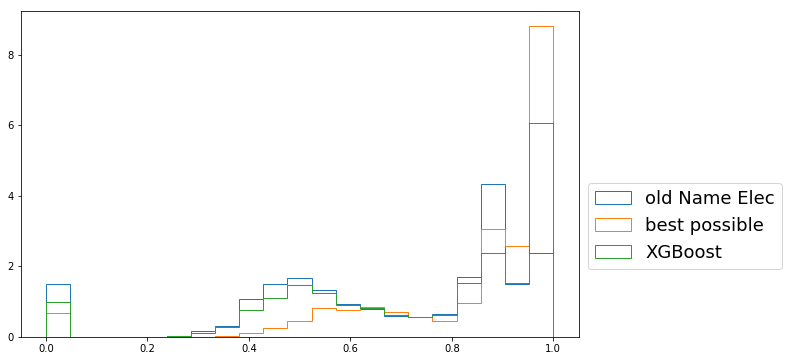

In [28]:
# Visualize the current results
plt.figure(figsize=(10,6))
plt.hist(dfb_test['elected_jw_match'],  bins=21,density=True,histtype='step',label='old Name Elec')
plt.hist(dfb_test['candidate_jw_match'],bins=21,density=True,histtype='step',label='best possible')
plt.hist(dfm_test['candidate_jw_match'],bins=21,density=True,histtype='step',label='XGBoost')
plt.legend(loc='best',prop={"size": 18},bbox_to_anchor=(1, 0.5))
plt.show()

In [29]:
# Summary of Current Name Election job, Model results, and comparison to the best possible:
# And the final contest score metric is calculated as the average JW string match of results to profile names.
def report_summary():
    p1 = (dfm_test['elected_jw_match']>=0.98).sum()/len(dfm_test)*100.
    p2 = (dfm_test['elected_jw_match']>=0.85).sum()/len(dfm_test)*100.
    p3 = (dfm_test['elected_jw_match']==0.  ).sum()/len(dfm_test)*100.
    p4 = dfm_test['elected_jw_match'].mean()
    print("Old Name Elec: \n\t% perfect:  {:0.2f}\n\t% good:     {:0.2f}\n\t% miss:     {:0.2f}\n\tMean match: {:0.2f}".format(p1,p2,p3,p4))
    print()
    p1 = (dfm_test['candidate_jw_match']>=0.98).sum()/len(dfm_test)*100.
    p2 = (dfm_test['candidate_jw_match']>=0.85).sum()/len(dfm_test)*100.
    p3 = (dfm_test['candidate_jw_match']==0.  ).sum()/len(dfm_test)*100.
    p4 = dfm_test['candidate_jw_match'].mean()
    print("ML Name Elec:  \n\t% perfect:  {:0.2f}\n\t% good:     {:0.2f}\n\t% miss:     {:0.2f}\n\tMean match: {:0.2f}".format(p1,p2,p3,p4))
    print()
    p1 = (dfb_test['candidate_jw_match']>=0.98).sum()/len(dfm_test)*100.
    p2 = (dfb_test['candidate_jw_match']>=0.85).sum()/len(dfm_test)*100.
    p3 = (dfb_test['candidate_jw_match']==0.  ).sum()/len(dfm_test)*100.
    p4 = dfb_test['candidate_jw_match'].mean()
    print("Best Possible:  \n\t% perfect:  {:0.2f}\n\t% good:     {:0.2f}\n\t% miss:     {:0.2f}\n\tMean match: {:0.2f}".format(p1,p2,p3,p4))

report_summary()

Old Name Elec: 
	% perfect:  10.00
	% good:     41.17
	% miss:     7.16
	Mean match: 0.68

ML Name Elec:  
	% perfect:  26.44
	% good:     48.83
	% miss:     4.76
	Mean match: 0.74

Best Possible:  
	% perfect:  37.97
	% good:     69.94
	% miss:     3.16
	Mean match: 0.84


Benchmark case for 'IN':
Old Name Elec: 
	% perfect:  9.03
	% good:     39.95
	% miss:     7.53
	Mean match: 0.67

ML Name Elec:  
	% perfect:  24.31
	% good:     47.97
	% miss:     4.89
	Mean match: 0.74

Best Possible:  
	% perfect:  35.99
	% good:     69.46
	% miss:     3.05
	Mean match: 0.84

In [30]:
# What are some examples where the ML model is very good and better than the old Name Election result
cut = (dfm_test['candidate_jw_match']>dfm_test['elected_jw_match']+0.2) & (dfm_test['candidate_jw_match']>=0.85)
dfm_test[cut][['profile_name','elected_name','candidate_name','elected_jw_match','candidate_jw_match']].head(50)

,profile_name,elected_name,candidate_name,elected_jw_match,candidate_jw_match
27,sonam kumari,mada manoj,sonamdkr,0.59,0.89
1069422,jyoti tiwary,tuki jio,jyoti tiwary,0.61,1.00
530819,abhirag murali,opr abhirag 2,abirag,0.63,0.85
1069528,swati basene,himani,swati basene,0.33,1.00
178295,vikram singh,happy,vikram singh,0.00,1.00
353736,anjaneyulu surubula,anji surubula battala shop tv,anjaneyulu surubula,0.73,1.00
353849,sayeed alli,arihant driver,seyad ali,0.54,0.91
536,mangalagiri rangadas,m.rangadas,mangalagirirangadas,0.67,0.99
178619,nimai garai,dada 3,nimai gorai stps,0.51,0.89
354122,mounika mouni,swathi new jio,mounika mouni,0.52,1.00


In [31]:
# What are some examples where the ML model completely misses but the old Name Election result was okay
cut = (dfm_test['candidate_jw_match']+0.2<=dfm_test['elected_jw_match']) & (dfm_test['elected_jw_match']>=0.85)
dfm_test[cut][['profile_name','elected_name','candidate_name','elected_jw_match','candidate_jw_match','score']].head(50)

,profile_name,elected_name,candidate_name,elected_jw_match,candidate_jw_match,score
353419,usha bagri,usha chaibasa,swati baby,0.86,0.62,0.168689
1069982,suresh bhai,suresh ravirayala,maharaj sureshpailwan,0.87,0.50,0.367905
710687,t ganesh,t ganesh,talari ganesh,1.00,0.52,0.338734
532163,mathavi mathavi,mathavi,punitha punitha,0.89,0.66,0.329581
355161,sathes v,sathes v,vino sathish,1.00,0.31,0.494663
711657,t. balaji,balaji,thapuharsitha,0.89,0.63,0.255535
893506,uaday pratap,uaday pratap,uday pratap dehwa,1.00,0.79,0.290835
180043,updesh sharma,updesh,sharma updesh,0.89,0.53,0.224561
712573,jitu ray,jitu ray,ray jitu,1.00,0.62,0.213146
894371,syed asif iqbal,syed asif iqbal,asif mazhari,1.00,0.54,0.555181
